In [82]:
%pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [83]:
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers,models, preprocessing
from matplotlib import pyplot as plt

In [84]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3 #RGB 


In [85]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("training_data/tomato_disease_category", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 16011 files belonging to 10 classes.


In [86]:
print(dataset.class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [87]:
print(len(dataset))

501


In [88]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    # 1 - 7 because we have 7 classes of tomato diseases
    print(label_batch.numpy()) #numpy() is used to convert tensor to numpy array


[[[146. 128. 124.]
  [144. 126. 122.]
  [155. 137. 133.]
  ...
  [155. 144. 140.]
  [165. 154. 150.]
  [185. 174. 170.]]

 [[136. 118. 114.]
  [162. 144. 140.]
  [165. 147. 143.]
  ...
  [184. 173. 169.]
  [181. 170. 166.]
  [171. 160. 156.]]

 [[129. 111. 107.]
  [148. 130. 126.]
  [127. 109. 105.]
  ...
  [208. 197. 193.]
  [185. 174. 170.]
  [166. 155. 151.]]

 ...

 [[151. 133. 133.]
  [127. 109. 109.]
  [120. 102. 102.]
  ...
  [130. 116. 115.]
  [131. 117. 116.]
  [143. 129. 128.]]

 [[139. 121. 121.]
  [118. 100. 100.]
  [128. 110. 110.]
  ...
  [129. 115. 114.]
  [131. 117. 116.]
  [145. 131. 130.]]

 [[149. 131. 131.]
  [129. 111. 111.]
  [123. 105. 105.]
  ...
  [146. 132. 131.]
  [147. 133. 132.]
  [144. 130. 129.]]]
[5 3 2 2 5 9 3 4 0 5 2 7 1 4 6 7 6 1 2 9 7 0 6 1 3 9 0 4 5 6 6 0]


2024-07-07 17:31:46.266115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [89]:
class_names=dataset.class_names
print(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


2024-07-07 17:31:46.311066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


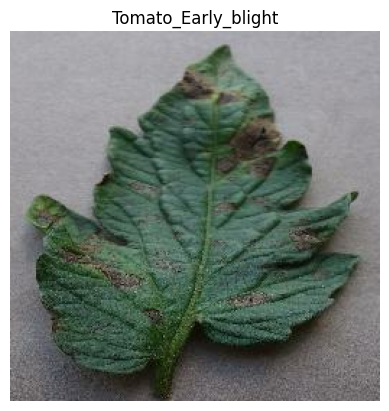

In [90]:
for image_batch,label_batch in dataset.take(1):
    plt.axis("off")
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))


2024-07-07 17:31:46.616794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


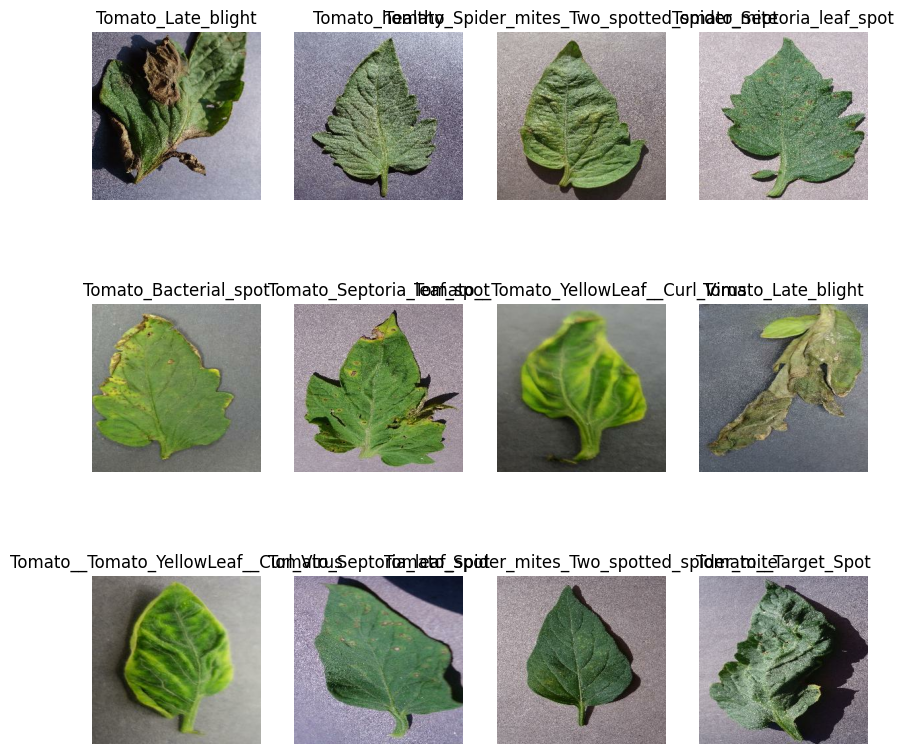

In [91]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

        

In [92]:
# 80% => training
# 20% => validation, testing

In [93]:
train_size=0.8
train_size=int(train_size*len(dataset))
print(train_size)


400


In [94]:
train_ds=dataset.take(train_size)
len(train_ds)


400

In [95]:
test_ds=dataset.skip(train_size)
len(test_ds)

101

In [96]:
val_size=0.1
len(dataset)*val_size

50.1

In [97]:
validation_ds=dataset.take(50)
testing_ds=dataset.skip(len(validation_ds))

In [98]:
#cleaner version of the above code
def generate_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_ds=ds.take(round(len(ds)*train_split))
    test_ds=ds.skip(len(train_ds))
    validation_ds=test_ds.take(round(len(test_ds)*val_split))
    testing_ds=test_ds.skip(len(validation_ds))
    print(f"Training: {len(train_ds)}")
    print(f"Validation: {len(validation_ds)}")
    print(f"Testing: {len(testing_ds)}")
    return train_ds, validation_ds, testing_ds

In [99]:
train_ds, validation_ds, testing_ds=generate_partitions_tf(dataset)

Training: 401
Validation: 10
Testing: 90


In [100]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
testing_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [103]:
# Rescaling and Rotation
rescale_and_resize=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [105]:
#Data Augmentation 
data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])